In [1]:
import tensorflow as tf
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

In [2]:
def loadData():
    data = io.loadmat("face_landmark.mat")
    images = data["images"]
    landmarks = data["landmarks"]
    print("im_shape:", images.shape)
    print("landmarks_shape:", landmarks.shape)

    return images, landmarks

In [3]:
images, landmarks = loadData()

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


# Visualize Data

In [4]:
def visualize_data(images, landmarks, num_images):
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(num_images):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        for (x, y) in landmarks[i].reshape(-1, 2):
            # Plot keypoints/landmarks on the image
            ax.scatter(x, y, marker='o', s=10, color='r')

    plt.show()

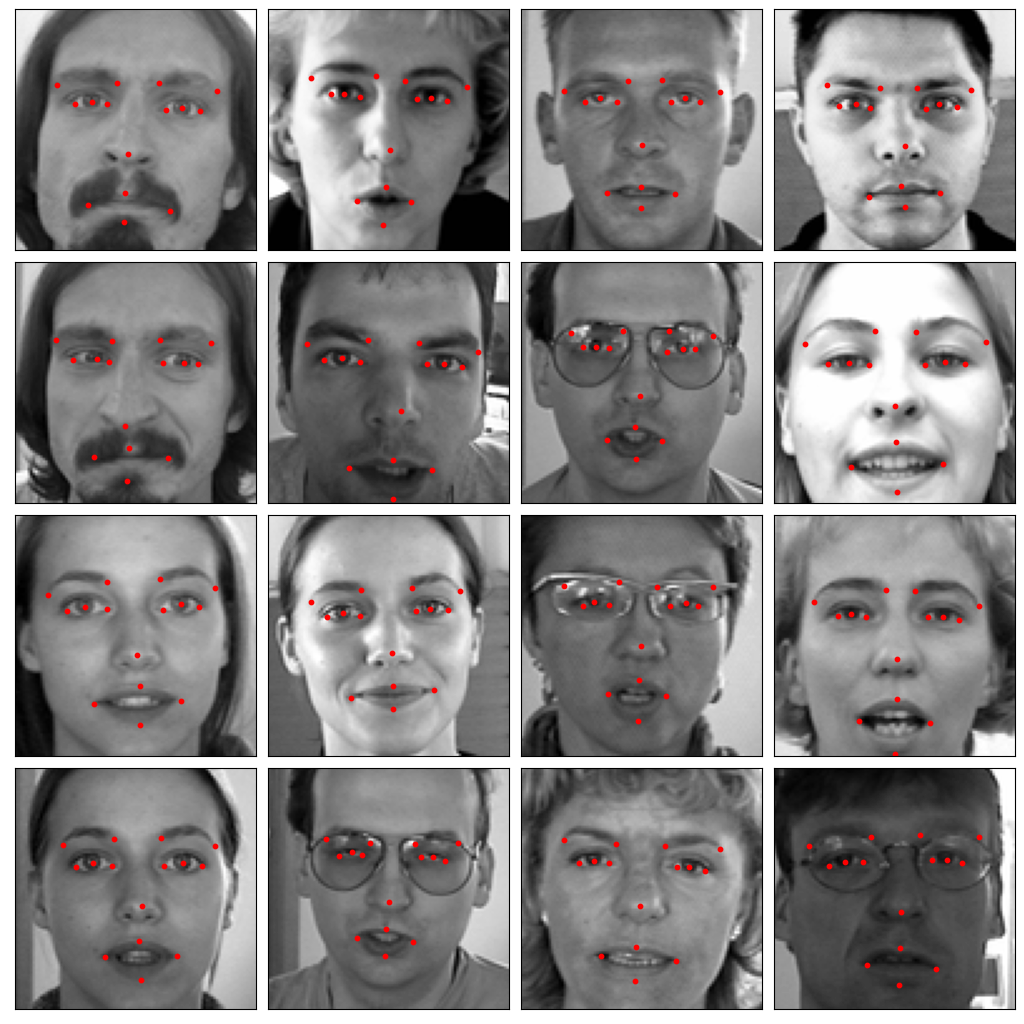

In [5]:
visualize_data(images, landmarks, num_images=16)

# Preprocessing

### split

In [6]:
def split_data(data, size):
    np.random.seed(2023)
    
    idx = np.random.permutation(size)

    train_size = int(size * 0.6)
    val_size = int(size * 0.2)
    test_size = int(size * 0.2)

    train_ds = data[idx[: train_size]]
    val_ds = data[idx[train_size: train_size + val_size]]
    test_ds = data[idx[size - test_size:]]

    return train_ds, val_ds, test_ds

In [7]:
train_img, val_img, test_img = split_data(images, images.shape[0])

In [8]:
train_lmrk, val_lmrk, test_lmrk = split_data(landmarks, landmarks.shape[0])

### Reshape

In [9]:
print(train_img.shape)
print(train_lmrk.shape)

(1284, 96, 96)
(1284, 15, 2)


In [10]:
print(val_img.shape)
print(val_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [11]:
print(test_img.shape)
print(test_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [12]:
train_lmrk = train_lmrk.reshape((1284, -1))
val_lmrk = val_lmrk.reshape((428, -1))
test_lmrk = test_lmrk.reshape((428, -1))

In [13]:
print(train_lmrk.shape)
print(val_lmrk.shape)
print(test_lmrk.shape)

(1284, 30)
(428, 30)
(428, 30)


# Model
* Output은 15개의 얼굴 랜드마크에 해당하는 x, y 좌표이므로 총 30개의 출력 유닛이 필요

In [14]:
# Define the input shape
input_layer = tf.keras.Input(shape=(96, 96, 1))

# Define the convolution and pooling layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the tensor output for the Fully Connected layer
x = tf.keras.layers.Flatten()(x)

# Define the fully connected layer
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Define the output layer (30 units for 15 landmarks x and y coordinates)
output_layer = tf.keras.layers.Dense(30)(x)

# Create the model
model = tf.keras.Model(input_layer, output_layer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496 

## Predict

In [15]:
@tf.function
def predict(x):
    return model(x, training=False)

# Optimization

In [16]:
@tf.function
def optimize(x,y_true,loss_function):
    with tf.GradientTape() as tape:
        y_pred = predict(x)
        loss = loss_function(y_pred, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Loss
* 실제 레이블(y_true)와 모델의 예측 결과(y)를 입력

In [18]:
@tf.function
def l1_loss(y_pred, y_true):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

@tf.function
def l2_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def cosine_loss(y_pred, y_true):
    # Normalize each vector
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    # Compute the dot product (cosine similarity)
    dot_product = tf.reduce_sum(y_true_normalized * y_pred_normalized, axis=-1)
    # Subtract the dot product from 1 to get the loss
    return 1 - tf.reduce_mean(dot_product)


In [19]:
def combine_l2_cosine_loss(y_pred, y_true, lamda=1.2):
    return l2_loss(y_pred, y_true) + lamda*cosine_loss(y_pred, y_true)

# Train & Evaluation

In [20]:
""" start training """
loss_function = combine_l2_cosine_loss

max_epochs = 1000
batch_size = 32


loss_history = []
val_loss_best = np.inf
train_size = int(images.shape[0] * 0.6)

#Early stopping hyperparameter
patience = 50  # number of epochs to wait before stopping if there is no improvement
wait = 0  # counter for epochs without improvement


for epoch in range(max_epochs):
    # get a minibatch
    idx = np.random.permutation(train_size)
    batch_idx = idx[:batch_size]

    # optimize
    train_loss = optimize(train_img[batch_idx], train_lmrk[batch_idx], loss_function)
    train_loss = train_loss.numpy()

    # evaluate on val_set
    y = predict(val_img)
    val_loss = loss_function(y, val_lmrk).numpy()

    # Early stopping check
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
        
    print('Epoch:', epoch, '. Training Loss:', train_loss, ' Validation Loss:', val_loss, ' Best Validation Loss:', val_loss_best)
    loss_history.append([train_loss, val_loss])

Epoch: 0 . Training Loss: 2728.8196  Validation Loss: 2283.6565  Best Validation Loss: 2283.6565
Epoch: 1 . Training Loss: 2276.222  Validation Loss: 2030.8992  Best Validation Loss: 2030.8992
Epoch: 2 . Training Loss: 2030.5558  Validation Loss: 1833.9913  Best Validation Loss: 1833.9913
Epoch: 3 . Training Loss: 1849.2913  Validation Loss: 1654.7446  Best Validation Loss: 1654.7446
Epoch: 4 . Training Loss: 1628.2806  Validation Loss: 1482.2411  Best Validation Loss: 1482.2411
Epoch: 5 . Training Loss: 1495.0553  Validation Loss: 1338.2148  Best Validation Loss: 1338.2148
Epoch: 6 . Training Loss: 1349.9294  Validation Loss: 1203.9167  Best Validation Loss: 1203.9167
Epoch: 7 . Training Loss: 1183.7941  Validation Loss: 1077.7505  Best Validation Loss: 1077.7505
Epoch: 8 . Training Loss: 1084.1691  Validation Loss: 980.64264  Best Validation Loss: 980.64264
Epoch: 9 . Training Loss: 965.29987  Validation Loss: 887.7138  Best Validation Loss: 887.7138
Epoch: 10 . Training Loss: 865.29

Epoch: 86 . Training Loss: 83.79664  Validation Loss: 126.31268  Best Validation Loss: 110.83738
Epoch: 87 . Training Loss: 134.04651  Validation Loss: 108.37043  Best Validation Loss: 108.37043
Epoch: 88 . Training Loss: 128.33173  Validation Loss: 144.61055  Best Validation Loss: 108.37043
Epoch: 89 . Training Loss: 131.79208  Validation Loss: 136.37532  Best Validation Loss: 108.37043
Epoch: 90 . Training Loss: 92.747116  Validation Loss: 108.20376  Best Validation Loss: 108.20376
Epoch: 91 . Training Loss: 126.21561  Validation Loss: 150.82915  Best Validation Loss: 108.20376
Epoch: 92 . Training Loss: 156.3198  Validation Loss: 150.24292  Best Validation Loss: 108.20376
Epoch: 93 . Training Loss: 186.51622  Validation Loss: 107.33385  Best Validation Loss: 107.33385
Epoch: 94 . Training Loss: 83.01889  Validation Loss: 124.861946  Best Validation Loss: 107.33385
Epoch: 95 . Training Loss: 82.97628  Validation Loss: 147.1869  Best Validation Loss: 107.33385
Epoch: 96 . Training Los

Epoch: 173 . Training Loss: 89.68096  Validation Loss: 96.875984  Best Validation Loss: 96.875984
Epoch: 174 . Training Loss: 79.474686  Validation Loss: 97.228264  Best Validation Loss: 96.875984
Epoch: 175 . Training Loss: 59.46366  Validation Loss: 97.936775  Best Validation Loss: 96.875984
Epoch: 176 . Training Loss: 100.550255  Validation Loss: 97.60093  Best Validation Loss: 96.875984
Epoch: 177 . Training Loss: 103.03405  Validation Loss: 104.12385  Best Validation Loss: 96.875984
Epoch: 178 . Training Loss: 100.329834  Validation Loss: 98.71771  Best Validation Loss: 96.875984
Epoch: 179 . Training Loss: 71.16877  Validation Loss: 105.13779  Best Validation Loss: 96.875984
Epoch: 180 . Training Loss: 75.00948  Validation Loss: 105.06391  Best Validation Loss: 96.875984
Epoch: 181 . Training Loss: 97.03123  Validation Loss: 99.58278  Best Validation Loss: 96.875984
Epoch: 182 . Training Loss: 87.17878  Validation Loss: 126.152626  Best Validation Loss: 96.875984
Epoch: 183 . Tra

Epoch: 258 . Training Loss: 89.122635  Validation Loss: 93.68432  Best Validation Loss: 87.10463
Epoch: 259 . Training Loss: 103.41076  Validation Loss: 90.32083  Best Validation Loss: 87.10463
Epoch: 260 . Training Loss: 75.75235  Validation Loss: 85.38419  Best Validation Loss: 85.38419
Epoch: 261 . Training Loss: 60.224667  Validation Loss: 95.38759  Best Validation Loss: 85.38419
Epoch: 262 . Training Loss: 90.70156  Validation Loss: 101.97787  Best Validation Loss: 85.38419
Epoch: 263 . Training Loss: 78.37846  Validation Loss: 86.50581  Best Validation Loss: 85.38419
Epoch: 264 . Training Loss: 111.52981  Validation Loss: 92.477036  Best Validation Loss: 85.38419
Epoch: 265 . Training Loss: 55.95414  Validation Loss: 110.739914  Best Validation Loss: 85.38419
Epoch: 266 . Training Loss: 113.68415  Validation Loss: 100.353714  Best Validation Loss: 85.38419
Epoch: 267 . Training Loss: 93.232925  Validation Loss: 85.214676  Best Validation Loss: 85.214676
Epoch: 268 . Training Loss

Epoch: 343 . Training Loss: 84.83591  Validation Loss: 83.35445  Best Validation Loss: 75.56762
Epoch: 344 . Training Loss: 76.2808  Validation Loss: 79.69869  Best Validation Loss: 75.56762
Epoch: 345 . Training Loss: 56.006706  Validation Loss: 76.13326  Best Validation Loss: 75.56762
Epoch: 346 . Training Loss: 60.64782  Validation Loss: 81.167694  Best Validation Loss: 75.56762
Epoch: 347 . Training Loss: 48.55923  Validation Loss: 82.51572  Best Validation Loss: 75.56762
Epoch: 348 . Training Loss: 77.78665  Validation Loss: 74.62715  Best Validation Loss: 74.62715
Epoch: 349 . Training Loss: 65.84318  Validation Loss: 78.58319  Best Validation Loss: 74.62715
Epoch: 350 . Training Loss: 83.72843  Validation Loss: 76.234215  Best Validation Loss: 74.62715
Epoch: 351 . Training Loss: 40.923153  Validation Loss: 75.592026  Best Validation Loss: 74.62715
Epoch: 352 . Training Loss: 51.927822  Validation Loss: 74.043755  Best Validation Loss: 74.043755
Epoch: 353 . Training Loss: 71.62

Epoch: 433 . Training Loss: 48.539635  Validation Loss: 81.76022  Best Validation Loss: 63.902203
Epoch: 434 . Training Loss: 46.012604  Validation Loss: 84.91502  Best Validation Loss: 63.902203
Epoch: 435 . Training Loss: 69.95913  Validation Loss: 64.29332  Best Validation Loss: 63.902203
Epoch: 436 . Training Loss: 55.262135  Validation Loss: 71.00362  Best Validation Loss: 63.902203
Epoch: 437 . Training Loss: 51.88703  Validation Loss: 65.515755  Best Validation Loss: 63.902203
Epoch: 438 . Training Loss: 31.63114  Validation Loss: 62.87883  Best Validation Loss: 62.87883
Epoch: 439 . Training Loss: 68.166565  Validation Loss: 70.873535  Best Validation Loss: 62.87883
Epoch: 440 . Training Loss: 52.82837  Validation Loss: 63.657707  Best Validation Loss: 62.87883
Epoch: 441 . Training Loss: 44.342556  Validation Loss: 65.02979  Best Validation Loss: 62.87883
Epoch: 442 . Training Loss: 39.879265  Validation Loss: 66.76836  Best Validation Loss: 62.87883
Epoch: 443 . Training Loss

Epoch: 521 . Training Loss: 54.62503  Validation Loss: 59.441254  Best Validation Loss: 56.616135
Epoch: 522 . Training Loss: 38.50473  Validation Loss: 56.914215  Best Validation Loss: 56.616135
Epoch: 523 . Training Loss: 47.501537  Validation Loss: 58.68144  Best Validation Loss: 56.616135
Epoch: 524 . Training Loss: 47.068962  Validation Loss: 59.34483  Best Validation Loss: 56.616135
Epoch: 525 . Training Loss: 49.685123  Validation Loss: 56.19462  Best Validation Loss: 56.19462
Epoch: 526 . Training Loss: 33.860447  Validation Loss: 66.76862  Best Validation Loss: 56.19462
Epoch: 527 . Training Loss: 34.739132  Validation Loss: 68.68711  Best Validation Loss: 56.19462
Epoch: 528 . Training Loss: 42.64742  Validation Loss: 57.898483  Best Validation Loss: 56.19462
Epoch: 529 . Training Loss: 44.518505  Validation Loss: 70.94661  Best Validation Loss: 56.19462
Epoch: 530 . Training Loss: 40.404766  Validation Loss: 69.45803  Best Validation Loss: 56.19462
Epoch: 531 . Training Loss

Epoch: 606 . Training Loss: 19.324604  Validation Loss: 53.475662  Best Validation Loss: 51.503498
Epoch: 607 . Training Loss: 26.557957  Validation Loss: 50.240337  Best Validation Loss: 50.240337
Epoch: 608 . Training Loss: 20.600052  Validation Loss: 51.14902  Best Validation Loss: 50.240337
Epoch: 609 . Training Loss: 31.832533  Validation Loss: 50.43435  Best Validation Loss: 50.240337
Epoch: 610 . Training Loss: 31.830547  Validation Loss: 51.61591  Best Validation Loss: 50.240337
Epoch: 611 . Training Loss: 42.23873  Validation Loss: 53.928905  Best Validation Loss: 50.240337
Epoch: 612 . Training Loss: 24.777151  Validation Loss: 52.080227  Best Validation Loss: 50.240337
Epoch: 613 . Training Loss: 31.138474  Validation Loss: 52.107574  Best Validation Loss: 50.240337
Epoch: 614 . Training Loss: 38.042385  Validation Loss: 53.89899  Best Validation Loss: 50.240337
Epoch: 615 . Training Loss: 30.400782  Validation Loss: 59.454807  Best Validation Loss: 50.240337
Epoch: 616 . Tr

Epoch: 695 . Training Loss: 53.344242  Validation Loss: 47.182434  Best Validation Loss: 45.825542
Epoch: 696 . Training Loss: 29.670347  Validation Loss: 50.70433  Best Validation Loss: 45.825542
Epoch: 697 . Training Loss: 27.43531  Validation Loss: 55.4289  Best Validation Loss: 45.825542
Epoch: 698 . Training Loss: 28.730581  Validation Loss: 48.89112  Best Validation Loss: 45.825542
Epoch: 699 . Training Loss: 26.000557  Validation Loss: 46.74455  Best Validation Loss: 45.825542
Epoch: 700 . Training Loss: 41.711327  Validation Loss: 48.847244  Best Validation Loss: 45.825542
Epoch: 701 . Training Loss: 24.688639  Validation Loss: 46.085434  Best Validation Loss: 45.825542
Epoch: 702 . Training Loss: 25.650696  Validation Loss: 52.215755  Best Validation Loss: 45.825542
Epoch: 703 . Training Loss: 27.806395  Validation Loss: 61.496178  Best Validation Loss: 45.825542
Epoch: 704 . Training Loss: 34.731277  Validation Loss: 54.982937  Best Validation Loss: 45.825542
Epoch: 705 . Tra

### visualization loss

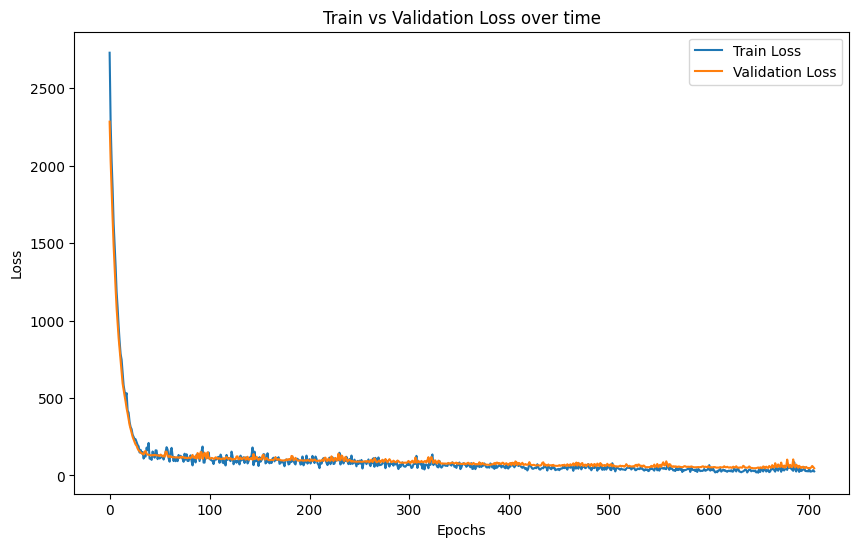

In [21]:
# Convert the history to a pandas dataframe
df_loss_history = pd.DataFrame(loss_history, columns=['train_loss', 'val_loss'])

# plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(df_loss_history['train_loss'], label='Train Loss')
plt.plot(df_loss_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over time')
plt.legend()
plt.show()


### Evaluation

In [22]:
test_true = test_lmrk
test_pred = model.predict(test_img)

print("Combine L2 And Cosine Error: ", combine_l2_cosine_loss(test_true, test_pred).numpy())

14/14 [==============================] - 0s 8ms/step
Combine L2 And Cosine Error:  45.263325


### visualize result

14/14 [==============================] - 0s 2ms/step


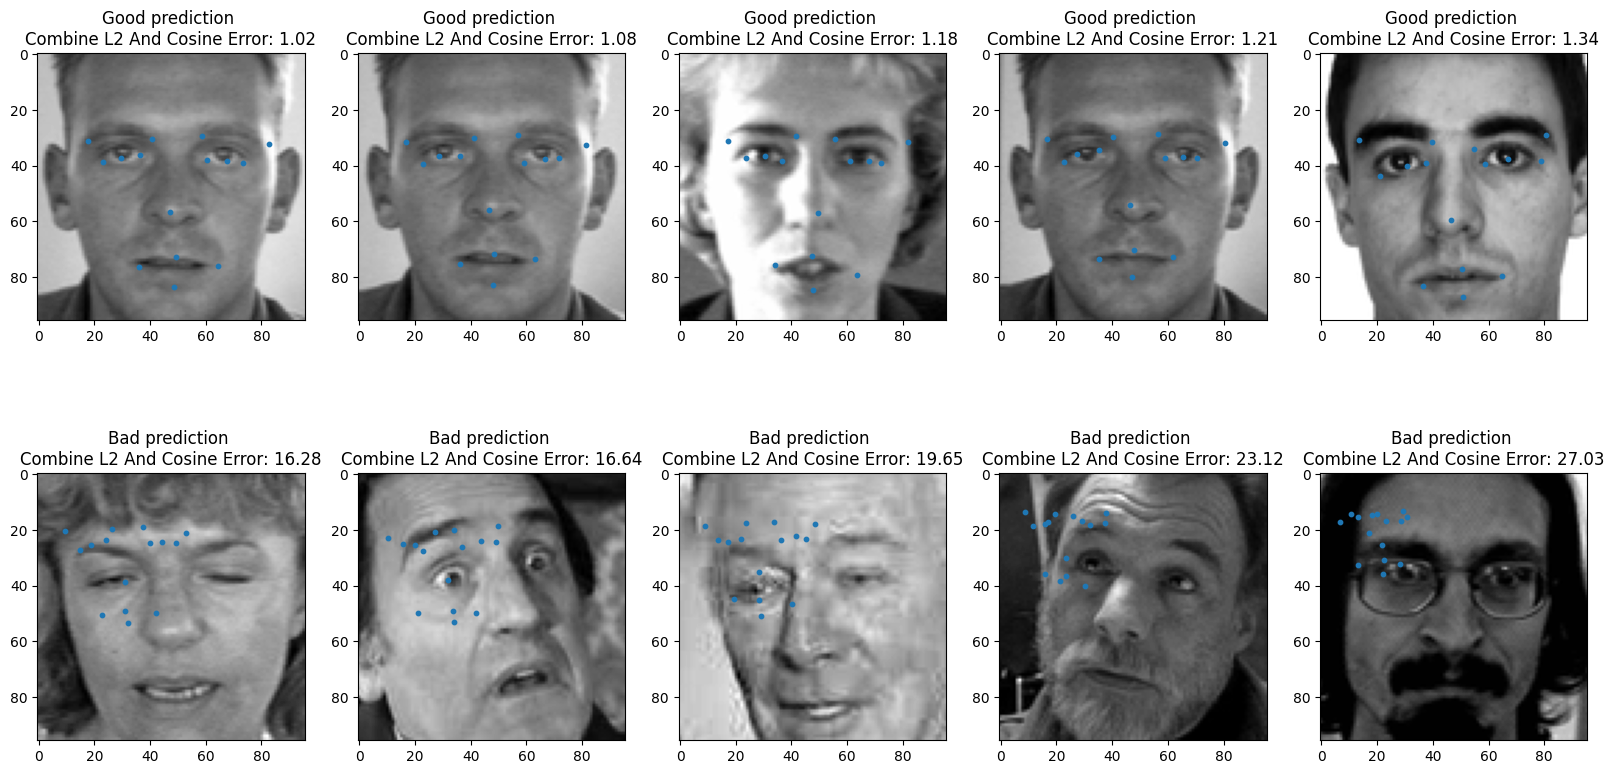

In [23]:
def plot_sample(image, landmarks, ax):
    ax.imshow(image, cmap='gray')
    landmarks = np.reshape(landmarks, (-1, 2)) # reshape to (15, 2)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='o', s=10)

# suppose we have some predictions and ground truth data
predictions = model.predict(test_img)
ground_truth = test_lmrk  # assume this exists

errors = np.mean(np.abs(predictions - ground_truth), axis=1)
sorted_indices = np.argsort(errors)

# Indices of good predictions
good_indices = sorted_indices[:5]  

# Indices of bad predictions
bad_indices = sorted_indices[-5:]  

fig = plt.figure(figsize=(20,10))
for i in range(5):
    # Good predictions
    ax = fig.add_subplot(2, 5, i+1)
    plot_sample(test_img[good_indices[i]], predictions[good_indices[i]], ax)
    ax.set_title("Good prediction \nCombine L2 And Cosine Error: {:.2f}".format(errors[good_indices[i]]))

    # Bad predictions
    ax = fig.add_subplot(2, 5, i+6)
    plot_sample(test_img[bad_indices[i]], predictions[bad_indices[i]], ax)
    ax.set_title("Bad prediction \nCombine L2 And Cosine Error: {:.2f}".format(errors[bad_indices[i]]))

plt.show()
